## LSST Afterglow detection metrics

Notebook for a mocked up GRB afterglow lightcurve. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

### On-axis afterglows

On-axis afterglows decay as $F \sim t^{-\alpha}$ until a jet break, with $\alpha \sim 1$.

This requires subclassing TransientMetric, which assumes linear rise & decays in magnitude.

We will use the rough numbers in 2011PASP..123.1034J: a Gaussian with $\mu$=15.35 mag, $\sigma=1.59$ in R-band at 1 minute after explosion, $\alpha = 1.0$.  
The right way to do this is not to assume fiducial values, but to simulate a cosmological population of events.


In [23]:
class GRBOnAxisMetric(metrics.TransientMetric):
    """Detections for GRB afterglows decaying as F(t) = F(1min)((t-t0)/1min)^-alpha.  No jet break, for now.
    
    alpha: temporal decay index
    apparent_mag_1min: magnitude at 1 minute after burst"""
    def __init__(self, alpha=1, apparent_mag_1min_mean=15.35, apparent_mag_1min_sigma=1.59, **kwargs):
        super( GRBOnAxisMetric, self ).__init__(**kwargs)
        self.alpha = alpha
        self.apparent_mag_1min_mean = apparent_mag_1min_mean
        self.apparent_mag_1min_sigma = apparent_mag_1min_sigma
        self.peakTime = 0
        
    def lightCurve(self, time, filters):
        """
        given the times and filters of an observation, return the magnitudes.
        """

        lcMags = np.zeros(time.size, dtype=float)

        #rise = np.where(time <= self.peakTime)
        #lcMags[rise] += self.riseSlope*time[rise]-self.riseSlope*self.peakTime
        decline = np.where(time > self.peakTime)
        apparent_mag_1min = np.random.randn()*self.apparent_mag_1min_sigma + self.apparent_mag_1min_mean
        lcMags[decline] += apparent_mag_1min + self.alpha * 2.5 * np.log10((time[decline]-self.peakTime)*24.*60.)

        #for key in self.peaks.keys():
        #    fMatch = np.where(filters == key)
        #    lcMags[fMatch] += self.peaks[key]

        return lcMags

Exception: Redefining metric __main__.GRBOnAxisMetric! (there are >1 metrics with the same name)

In [3]:
year = 9

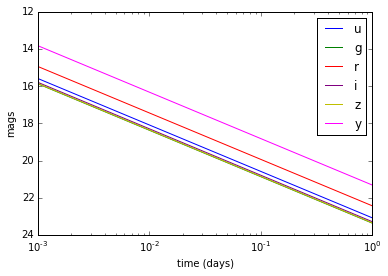

In [8]:
# Trying to make an orphan GRB-like light curve
#peaks = {'uPeak':35, 'gPeak':23., 'rPeak':22.5, 'iPeak':22., 'zPeak':21.5,'yPeak':21.5}

colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 1.1 # Days
transMetric = GRBOnAxisMetric(alpha= 1.,surveyDuration=1)


#times = np.linspace(0.,transDuration*2,200) 
times = np.logspace(-3,0,500)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
#plt.ylim([35,18])
plt.gca().invert_yaxis()
plt.xscale('log')
plt.legend()

In [9]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of 60-day, r=20 mag flat transients are detected at least once?
metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [10]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 3287.250000 and 3652.500000
Found 231251 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.249605  dipole: lon: 94.3719, lat: -17.7054, amp: 0.0585855
Plotting complete.


/home/maf/miniconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3759: SAWarning: Textual SQL expression 'night between 3287.250000...' should be explicitly declared as text('night between 3287.250000...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


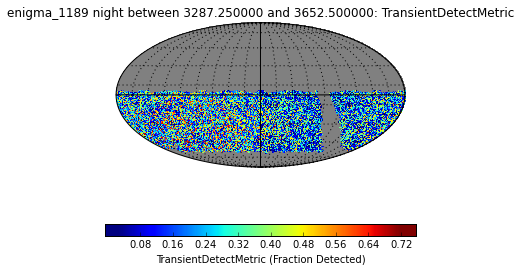

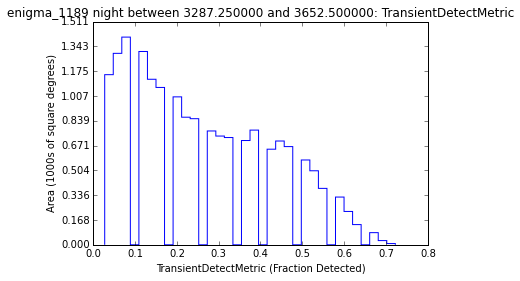

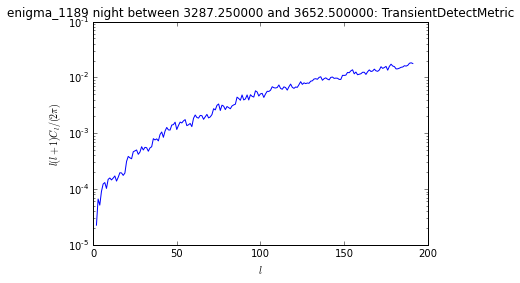

In [11]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [12]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

TransientDetectMetric {'Median': 0.22222222222222221}


So about a quarter of these afterglows would be detected in at least one epoch.

Now ask how many we can detect with 3 points per lightcurve (no restriction on same band, because TransientMetric doesn't allow it.)

In [20]:
transMetric = GRBOnAxisMetric(alpha= 1., surveyDuration=1, nPerLC=3)

#transMetric = metrics.TransientMetric(riseSlope= -1.5, declineSlope=0.2, 
#                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
#                                      nFilters=4, nPrePeak=2, nPerLC=1, **peaks)

sqlconstraint = 'night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 3287.250000 and 3652.500000
Found 231251 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.0403751  dipole: lon: -64.3205, lat: 36.8884, amp: 0.00714309
Plotting complete.


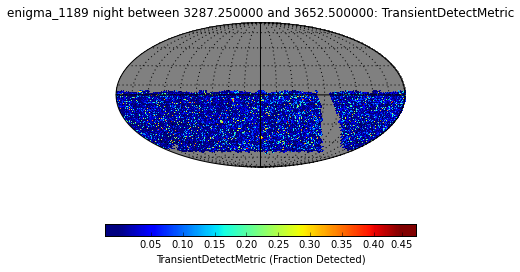

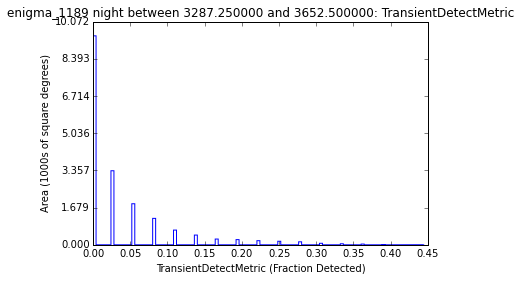

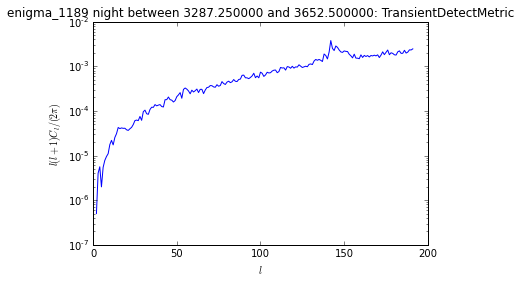

In [21]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)


In [19]:
transBundle.summaryValues

{'Median': 0.1111111111111111}

So demanding three detections (in any filter) drops us to a 0% median detection rate.  Two detections is at 11%

## Original old stuff


Fast rise :
1 mag in 2 day rise
Reasonably fast decline :
2 mag in 10 day decline 

Pick 22.5 as a typical peak mag. Say z~1-2 (all data above are estimates from Nial Tanvir)

Fairly flat colours. 


Require : 6 points total and 1 night all 4 filters 

Summary - if we  Requesting 4 filters on rise AND decline == zero efficiency

If we requesting 4 filters at some stage gives ~4 percent efficiency 

Typical sky density is 

1 per 1000 dq dg 

therefore about 

18 per yr 

And with these efficiencies we are likely to detect < 1 object per yr. 

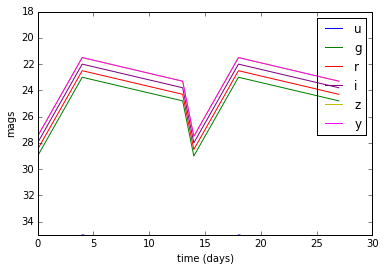

In [3]:
# Trying to make an orphan GRB-like light curve
peaks = {'uPeak':35, 'gPeak':23., 'rPeak':22.5, 'iPeak':22., 'zPeak':21.5,'yPeak':21.5}

colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

peakTime = 4.
transDuration = peakTime+10. # Days
transMetric = metrics.TransientMetric(riseSlope= -1.5, declineSlope=0.2, 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, **peaks)


times = np.arange(0.,transDuration*2,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

In [18]:

transMetric = metrics.TransientMetric(riseSlope= -1.5, declineSlope=0.2, 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=4, nPrePeak=2, nPerLC=1, **peaks)

sqlconstraint = 'night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)